Uso de EfficientNet-B0 para clasificación de melanoma utilizando la base de datos de Harvard.

In [36]:
#matriz de confusión
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd

In [37]:
import torch
print("¿GPU disponible?:", torch.cuda.is_available())
print("Nombre de la GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No hay GPU")


¿GPU disponible?: True
Nombre de la GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [38]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
# Definir directorios
base_dir = r"C:\Users\jakif\CODE\PROYECTO-FINAL\images\PREPROCESSED_DATA_copy"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')



transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),  # Melanomas pueden aparecer en cualquier orientación
    transforms.RandomRotation(30),  # Aumentado a 30 grados
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Añadido transformaciones afines
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variaciones de color
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización ImageNet (más estándar)
])

# Transformación separada para validación/test (sin augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Actualizar datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Crear DataLoaders para entrenamiento y prueba
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Clases
print("Clases:", train_dataset.classes)


Clases: ['benign_images', 'malignant_images']


# ¡¡¡¡EFFIcientNetB7!!!!!



In [39]:
import torch.nn as nn
import torchvision.models as models

# Cargar modelo preentrenado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo:", device)
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)  # Cargar EfficientNet-B0 preentrenado

# Congelar algunas capas iniciales para evitar overfit
for param in list(model.parameters())[:-20]:  # Mantener solo los últimos bloques para entrenamiento
    param.requires_grad = False

# Reemplazar el clasificador con una secuencia más compleja
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),  # Aumentado a 0.3 para regularización
    nn.Linear(in_features=1280, out_features=512),
    nn.BatchNorm1d(512),  # Batch normalization
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(in_features=512, out_features=128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(in_features=128, out_features=1)  # Salida final para clasificación binaria
)

model = model.to(device)
print(model)


Dispositivo: cuda
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2):

Se añade una funcion especifica para controlar el desbalanceo de las clases

In [40]:
def calculate_class_weights(train_dataset):
    # Contar la frecuencia de cada clase
    class_counts = [0] * len(train_dataset.classes)
    for _, label in train_dataset.samples:
        class_counts[label] += 1
    
    total_samples = sum(class_counts)
    # Calcular los pesos inversamente proporcionales a la frecuencia de clase
    class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]
    print(f"Num Classes: {class_counts}")
    print(f"Weights for each class: {class_weights}")
    return torch.FloatTensor(class_weights).to(device)

# Calcular pesos para las clases
class_weights = calculate_class_weights(train_dataset)

# Actualizar el criterio de pérdida con los pesos
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weights[1]/class_weights[0]]).to(device))

Num Classes: [6705, 1113]
Weights for each class: [0.5829977628635347, 3.512129380053908]


In [41]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Estrategia de entrenamiento por grupos con diferentes tasas de aprendizaje
# Parámetros de las capas congeladas (iniciales)
frozen_params = list(map(id, [p for n, p in model.named_parameters() if p.requires_grad == False]))
# Parámetros de las nuevas capas (clasificador)
new_params = [p for n, p in model.named_parameters() if id(p) not in frozen_params]

# Configuración del optimizador con tasas diferenciadas y regularización
optimizer = optim.AdamW([
    {'params': [p for p in model.parameters() if p.requires_grad == False], 'lr': 0.0},  # No entrenar capas congeladas
    {'params': [p for p in model.parameters() if (p.requires_grad == True and id(p) not in map(id, new_params))], 'lr': 0.0001},  # Capas intermedias
    {'params': new_params, 'lr': 0.001}  # Nuevas capas (clasificador)
], weight_decay=1e-4)  # Aumentada regularización L2

# Scheduler más avanzado: cosine annealing con warm restarts
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)



In [42]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=50):
    history = {
        'train_loss': [], 'train_accuracy': [], 'train_recall': [], 'train_precision': [], 'train_f1': [], 'train_dice': [], 'train_aucroc': [],
        'val_loss': [], 'val_accuracy': [], 'val_recall': [], 'val_precision': [], 'val_f1': [], 'val_dice': [], 'val_aucroc': [],
        'lr': [], 'best_epoch': 0, 'best_f1': 0.0
    }
    
    best_val_f1 = 0.0
    early_stopping_patience = 10
    patience_counter = 0
    
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_labels = []
        all_preds = []
        all_probs = []
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.float32)
            
            optimizer.zero_grad()
            
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(images).squeeze()
                    loss = criterion(outputs, labels)
                
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            running_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = torch.round(probs)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.detach().cpu().numpy())  # Use detach() to avoid the RuntimeError
            all_probs.extend(probs.detach().cpu().numpy())
        
        train_metrics = calculate_metrics(np.array(all_labels), np.array(all_preds), np.array(all_probs))
        train_loss = running_loss / len(train_loader)
        
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_metrics['accuracy'])
        history['train_recall'].append(train_metrics['recall'])
        history['train_precision'].append(train_metrics['precision'])
        history['train_f1'].append(train_metrics['f1'])
        history['train_dice'].append(train_metrics['dice'])
        history['train_aucroc'].append(train_metrics['aucroc'])
        
        val_metrics, val_loss = evaluate_model(model, test_loader, criterion)
        
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_metrics['accuracy'])
        history['val_recall'].append(val_metrics['recall'])
        history['val_precision'].append(val_metrics['precision'])
        history['val_f1'].append(val_metrics['f1'])
        history['val_dice'].append(val_metrics['dice'])
        history['val_aucroc'].append(val_metrics['aucroc'])
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        scheduler.step()
        
        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            history['best_f1'] = best_val_f1
            history['best_epoch'] = epoch + 1
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'val_f1': best_val_f1,
                'val_loss': val_loss
            }, 'best_model_EFFICIENTB0_improved_2.pth')
            print(f"✅ Guardado mejor modelo en epoch {epoch+1} con F1 = {best_val_f1:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"⚠️ Early stopping en epoch {epoch+1}!")
                break
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_metrics['accuracy']:.2f}%, "
              f"Recall: {train_metrics['recall']:.4f}, Prec: {train_metrics['precision']:.4f}, "
              f"F1: {train_metrics['f1']:.4f}, Dice: {train_metrics['dice']:.4f}, AUC-ROC: {train_metrics['aucroc']:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_metrics['accuracy']:.2f}%, "
              f"Recall: {val_metrics['recall']:.4f}, Prec: {val_metrics['precision']:.4f}, "
              f"F1: {val_metrics['f1']:.4f}, Dice: {val_metrics['dice']:.4f}, AUC-ROC: {val_metrics['aucroc']:.4f}")
        print(f"LR: {optimizer.param_groups[-1]['lr']:.2e}, Patience: {patience_counter}/{early_stopping_patience}")
        print("-" * 80)
    
    checkpoint = torch.load('best_model_EFFICIENTB0_improved_2.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✨ Entrenamiento completado. Mejor F1: {best_val_f1:.4f} en epoch {history['best_epoch']}")
    return history, model

def calculate_metrics(y_true, y_pred, y_probs=None):
    """Calcula métricas de clasificación binaria"""
    from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
    
    accuracy = accuracy_score(y_true, y_pred) * 100
    recall = recall_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    dice = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    aucroc = roc_auc_score(y_true, y_probs) if y_probs is not None else 0.0
    
    return {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'dice': dice,
        'aucroc': aucroc
    }

def evaluate_model(model, test_loader, criterion=None):
    """Evalúa el modelo y devuelve métricas y pérdida"""
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    running_loss = 0.0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.float32)
            
            outputs = model(images).squeeze()
            
            if criterion is not None:
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
            probs = torch.sigmoid(outputs)
            preds = torch.round(probs)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.detach().cpu().numpy())  # Use detach() to avoid the RuntimeError
            all_probs.extend(probs.detach().cpu().numpy())  # Use detach() to avoid the RuntimeError
    
    metrics = calculate_metrics(np.array(all_labels), np.array(all_preds), np.array(all_probs))
    val_loss = running_loss / len(test_loader) if criterion is not None else 0.0
    
    return metrics, val_loss


In [43]:
history = train_model(model, train_loader, test_loader, criterion, optimizer,scheduler, epochs=30)

C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ Guardado mejor modelo en epoch 1 con F1 = 0.5492
Epoch 1/30
Train - Loss: 0.8162, Acc: 75.52%, Recall: 0.7978, Prec: 0.3446, F1: 0.4813, Dice: 0.4813, AUC-ROC: 0.8526
Val   - Loss: 0.6685, Acc: 75.81%, Recall: 0.9298, Prec: 0.3897, F1: 0.5492, Dice: 0.5492, AUC-ROC: 0.9149
LR: 9.05e-04, Patience: 0/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ Guardado mejor modelo en epoch 2 con F1 = 0.6213
Epoch 2/30
Train - Loss: 0.7419, Acc: 80.60%, Recall: 0.7987, Prec: 0.4074, F1: 0.5396, Dice: 0.5396, AUC-ROC: 0.8860
Val   - Loss: 0.7059, Acc: 84.52%, Recall: 0.8012, Prec: 0.5074, F1: 0.6213, Dice: 0.6213, AUC-ROC: 0.9156
LR: 6.55e-04, Patience: 0/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ Guardado mejor modelo en epoch 3 con F1 = 0.6404
Epoch 3/30
Train - Loss: 0.6684, Acc: 82.62%, Recall: 0.8275, Prec: 0.4411, F1: 0.5754, Dice: 0.5754, AUC-ROC: 0.9071
Val   - Loss: 0.7533, Acc: 85.63%, Recall: 0.8070, Prec: 0.5308, F1: 0.6404, Dice: 0.6404, AUC-ROC: 0.9123
LR: 3.46e-04, Patience: 0/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ Guardado mejor modelo en epoch 4 con F1 = 0.6652
Epoch 4/30
Train - Loss: 0.6585, Acc: 84.19%, Recall: 0.8185, Prec: 0.4684, F1: 0.5958, Dice: 0.5958, AUC-ROC: 0.9106
Val   - Loss: 0.6593, Acc: 86.28%, Recall: 0.8596, Prec: 0.5424, F1: 0.6652, Dice: 0.6652, AUC-ROC: 0.9256
LR: 9.64e-05, Patience: 0/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/30
Train - Loss: 0.6158, Acc: 83.73%, Recall: 0.8293, Prec: 0.4603, F1: 0.5920, Dice: 0.5920, AUC-ROC: 0.9183
Val   - Loss: 0.6448, Acc: 84.71%, Recall: 0.8830, Prec: 0.5101, F1: 0.6467, Dice: 0.6467, AUC-ROC: 0.9275
LR: 1.00e-03, Patience: 1/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6/30
Train - Loss: 0.6738, Acc: 82.57%, Recall: 0.8140, Prec: 0.4394, F1: 0.5707, Dice: 0.5707, AUC-ROC: 0.9080
Val   - Loss: 0.6900, Acc: 86.38%, Recall: 0.7719, Prec: 0.5500, F1: 0.6423, Dice: 0.6423, AUC-ROC: 0.9245
LR: 9.76e-04, Patience: 2/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7/30
Train - Loss: 0.6473, Acc: 83.05%, Recall: 0.8284, Prec: 0.4484, F1: 0.5819, Dice: 0.5819, AUC-ROC: 0.9132
Val   - Loss: 0.7617, Acc: 86.19%, Recall: 0.8246, Prec: 0.5423, F1: 0.6543, Dice: 0.6543, AUC-ROC: 0.9110
LR: 9.05e-04, Patience: 3/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8/30
Train - Loss: 0.6532, Acc: 84.64%, Recall: 0.8194, Prec: 0.4770, F1: 0.6030, Dice: 0.6030, AUC-ROC: 0.9152
Val   - Loss: 0.7670, Acc: 85.17%, Recall: 0.7895, Prec: 0.5212, F1: 0.6279, Dice: 0.6279, AUC-ROC: 0.9157
LR: 7.94e-04, Patience: 4/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9/30
Train - Loss: 0.5993, Acc: 85.30%, Recall: 0.8257, Prec: 0.4904, F1: 0.6153, Dice: 0.6153, AUC-ROC: 0.9252
Val   - Loss: 0.7596, Acc: 87.03%, Recall: 0.8012, Prec: 0.5638, F1: 0.6618, Dice: 0.6618, AUC-ROC: 0.9172
LR: 6.55e-04, Patience: 5/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10/30
Train - Loss: 0.5634, Acc: 86.19%, Recall: 0.8374, Prec: 0.5090, F1: 0.6332, Dice: 0.6332, AUC-ROC: 0.9352
Val   - Loss: 0.7345, Acc: 86.38%, Recall: 0.8187, Prec: 0.5469, F1: 0.6557, Dice: 0.6557, AUC-ROC: 0.9239
LR: 5.01e-04, Patience: 6/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 11/30
Train - Loss: 0.5664, Acc: 85.92%, Recall: 0.8365, Prec: 0.5032, F1: 0.6284, Dice: 0.6284, AUC-ROC: 0.9343
Val   - Loss: 0.7418, Acc: 85.63%, Recall: 0.8304, Prec: 0.5299, F1: 0.6469, Dice: 0.6469, AUC-ROC: 0.9223
LR: 3.46e-04, Patience: 7/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 12/30
Train - Loss: 0.5859, Acc: 86.99%, Recall: 0.8194, Prec: 0.5278, F1: 0.6420, Dice: 0.6420, AUC-ROC: 0.9336
Val   - Loss: 0.8413, Acc: 87.95%, Recall: 0.7427, Prec: 0.5962, F1: 0.6615, Dice: 0.6615, AUC-ROC: 0.9217
LR: 2.07e-04, Patience: 8/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ Guardado mejor modelo en epoch 13 con F1 = 0.6682
Epoch 13/30
Train - Loss: 0.5850, Acc: 86.48%, Recall: 0.8338, Prec: 0.5156, F1: 0.6371, Dice: 0.6371, AUC-ROC: 0.9344
Val   - Loss: 0.7649, Acc: 87.03%, Recall: 0.8246, Prec: 0.5618, F1: 0.6682, Dice: 0.6682, AUC-ROC: 0.9221
LR: 9.64e-05, Patience: 0/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ Guardado mejor modelo en epoch 14 con F1 = 0.6800
Epoch 14/30
Train - Loss: 0.5566, Acc: 87.44%, Recall: 0.8356, Prec: 0.5379, F1: 0.6545, Dice: 0.6545, AUC-ROC: 0.9401
Val   - Loss: 0.7900, Acc: 88.14%, Recall: 0.7953, Prec: 0.5939, F1: 0.6800, Dice: 0.6800, AUC-ROC: 0.9237
LR: 2.54e-05, Patience: 0/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ Guardado mejor modelo en epoch 15 con F1 = 0.6851
Epoch 15/30
Train - Loss: 0.5548, Acc: 87.96%, Recall: 0.8392, Prec: 0.5507, F1: 0.6650, Dice: 0.6650, AUC-ROC: 0.9405
Val   - Loss: 0.7973, Acc: 88.42%, Recall: 0.7953, Prec: 0.6018, F1: 0.6851, Dice: 0.6851, AUC-ROC: 0.9229
LR: 1.00e-03, Patience: 0/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 16/30
Train - Loss: 0.6186, Acc: 85.52%, Recall: 0.8221, Prec: 0.4949, F1: 0.6178, Dice: 0.6178, AUC-ROC: 0.9265
Val   - Loss: 1.2619, Acc: 86.38%, Recall: 0.7427, Prec: 0.5522, F1: 0.6334, Dice: 0.6334, AUC-ROC: 0.8826
LR: 9.94e-04, Patience: 1/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 17/30
Train - Loss: 0.6141, Acc: 85.33%, Recall: 0.8230, Prec: 0.4909, F1: 0.6150, Dice: 0.6150, AUC-ROC: 0.9270
Val   - Loss: 0.6561, Acc: 85.08%, Recall: 0.8421, Prec: 0.5180, F1: 0.6414, Dice: 0.6414, AUC-ROC: 0.9296
LR: 9.76e-04, Patience: 2/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 18/30
Train - Loss: 0.5942, Acc: 85.14%, Recall: 0.8473, Prec: 0.4873, F1: 0.6188, Dice: 0.6188, AUC-ROC: 0.9297
Val   - Loss: 0.8420, Acc: 87.67%, Recall: 0.7427, Prec: 0.5880, F1: 0.6563, Dice: 0.6563, AUC-ROC: 0.9236
LR: 9.46e-04, Patience: 3/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 19/30
Train - Loss: 0.5910, Acc: 86.77%, Recall: 0.8392, Prec: 0.5221, F1: 0.6437, Dice: 0.6437, AUC-ROC: 0.9323
Val   - Loss: 0.6899, Acc: 87.12%, Recall: 0.8129, Prec: 0.5650, F1: 0.6667, Dice: 0.6667, AUC-ROC: 0.9293
LR: 9.05e-04, Patience: 4/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 20/30
Train - Loss: 0.5443, Acc: 87.09%, Recall: 0.8275, Prec: 0.5299, F1: 0.6461, Dice: 0.6461, AUC-ROC: 0.9412
Val   - Loss: 0.7280, Acc: 83.13%, Recall: 0.8538, Prec: 0.4818, F1: 0.6160, Dice: 0.6160, AUC-ROC: 0.9194
LR: 8.54e-04, Patience: 5/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 21/30
Train - Loss: 0.5461, Acc: 87.18%, Recall: 0.8509, Prec: 0.5311, F1: 0.6540, Dice: 0.6540, AUC-ROC: 0.9418
Val   - Loss: 0.7998, Acc: 85.73%, Recall: 0.8012, Prec: 0.5331, F1: 0.6402, Dice: 0.6402, AUC-ROC: 0.9134
LR: 7.94e-04, Patience: 6/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 22/30
Train - Loss: 0.5384, Acc: 87.99%, Recall: 0.8311, Prec: 0.5519, F1: 0.6633, Dice: 0.6633, AUC-ROC: 0.9436
Val   - Loss: 0.8419, Acc: 86.38%, Recall: 0.7251, Prec: 0.5536, F1: 0.6278, Dice: 0.6278, AUC-ROC: 0.9109
LR: 7.27e-04, Patience: 7/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 23/30
Train - Loss: 0.5468, Acc: 88.86%, Recall: 0.8455, Prec: 0.5738, F1: 0.6836, Dice: 0.6836, AUC-ROC: 0.9449
Val   - Loss: 0.6957, Acc: 85.08%, Recall: 0.8129, Prec: 0.5187, F1: 0.6333, Dice: 0.6333, AUC-ROC: 0.9221
LR: 6.55e-04, Patience: 8/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 24/30
Train - Loss: 0.5159, Acc: 89.05%, Recall: 0.8509, Prec: 0.5785, F1: 0.6887, Dice: 0.6887, AUC-ROC: 0.9479
Val   - Loss: 0.8988, Acc: 86.75%, Recall: 0.7836, Prec: 0.5583, F1: 0.6521, Dice: 0.6521, AUC-ROC: 0.9151
LR: 5.79e-04, Patience: 9/10
--------------------------------------------------------------------------------


C:\Users\jakif\AppData\Local\Temp\ipykernel_36012\1704452010.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


⚠️ Early stopping en epoch 25!
✨ Entrenamiento completado. Mejor F1: 0.6851 en epoch 15


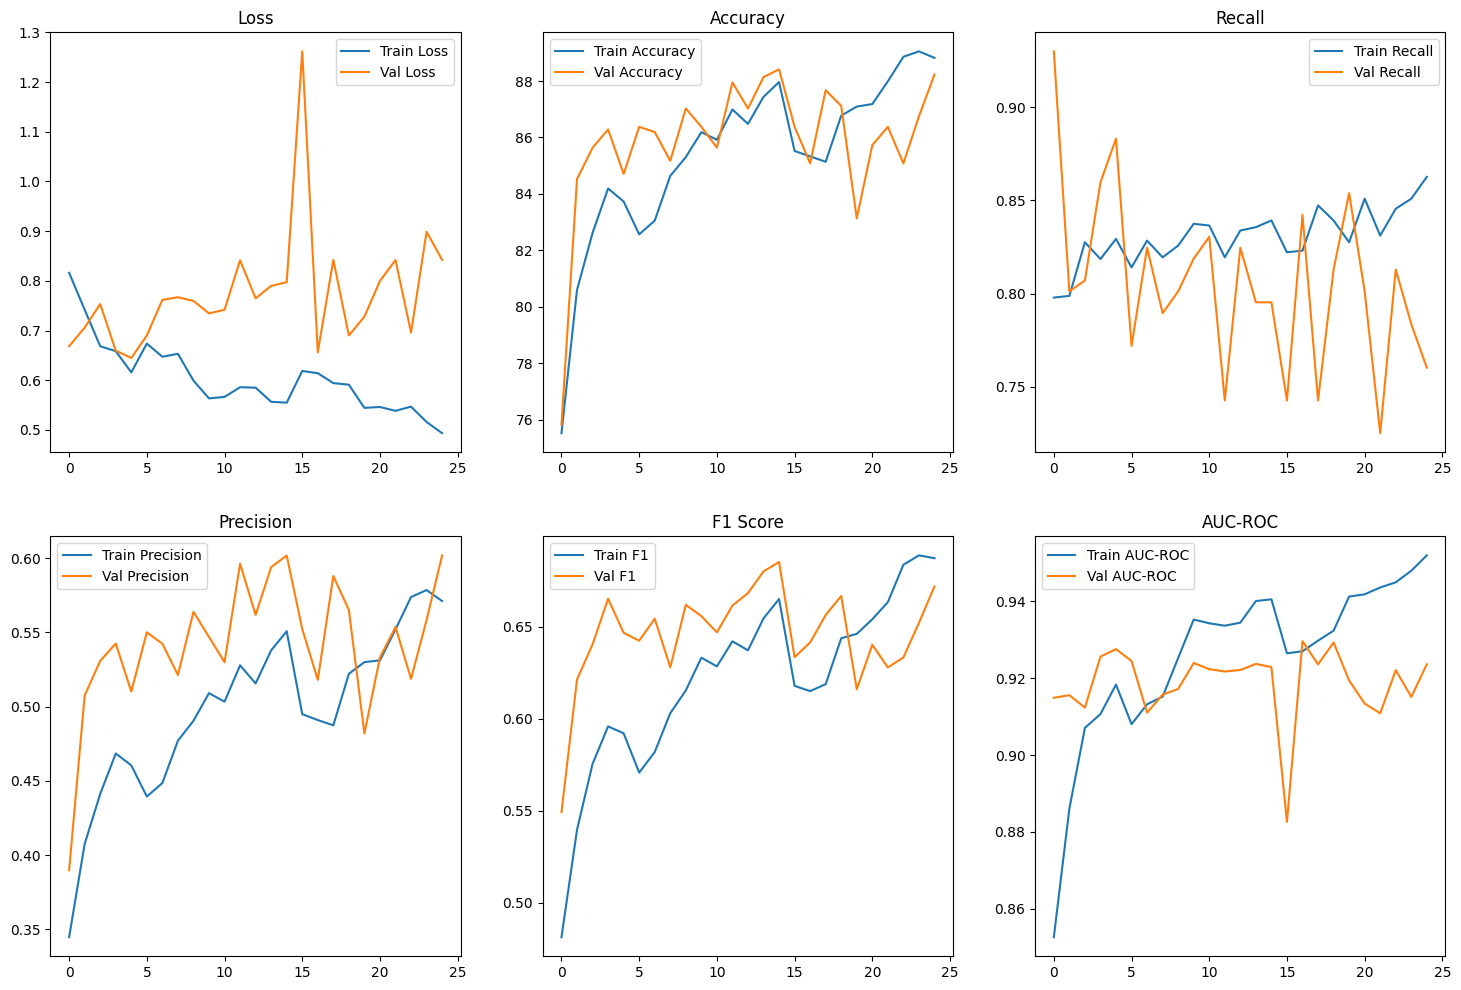

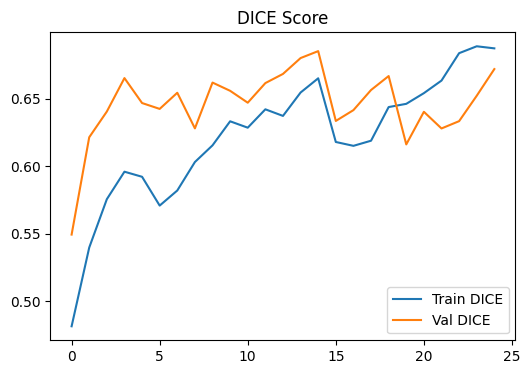

In [45]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(18, 12))
    
    # Gráfico de pérdida
    plt.subplot(2, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    
    # Gráfico de accuracy
    plt.subplot(2, 3, 2)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    # Gráfico de recall
    plt.subplot(2, 3, 3)
    plt.plot(history['train_recall'], label='Train Recall')
    plt.plot(history['val_recall'], label='Val Recall')
    plt.title('Recall')
    plt.legend()
    
    # Gráfico de precision
    plt.subplot(2, 3, 4)
    plt.plot(history['train_precision'], label='Train Precision')
    plt.plot(history['val_precision'], label='Val Precision')
    plt.title('Precision')
    plt.legend()
    
    # Gráfico de F1
    plt.subplot(2, 3, 5)
    plt.plot(history['train_f1'], label='Train F1')
    plt.plot(history['val_f1'], label='Val F1')
    plt.title('F1 Score')
    plt.legend()
    
    # Gráfico de AUC-ROC
    plt.subplot(2, 3, 6)
    plt.plot(history['train_aucroc'], label='Train AUC-ROC')
    plt.plot(history['val_aucroc'], label='Val AUC-ROC')
    plt.title('AUC-ROC')
    plt.legend()
    
    # Gráfico de DICE
    plt.figure(figsize=(6, 4))
    plt.plot(history['train_dice'], label='Train DICE')
    plt.plot(history['val_dice'], label='Val DICE')
    plt.title('DICE Score')
    plt.legend()
    plt.show()

# Mostrar gráficos
plot_history(history[0])  # Access the first element of the tuple, which is the dictionary

In [46]:

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.show()

In [47]:

# Evaluar el modelo
def evaluate_model(model, test_loader):
    model.eval()  # Modo evaluación
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.float32)
            outputs = model(images).squeeze()
            preds = torch.round(torch.sigmoid(outputs))  # Convertir logits en 0 o 1

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

                  precision    recall  f1-score   support

   benign_images       0.96      0.90      0.93       908
malignant_images       0.60      0.80      0.69       171

        accuracy                           0.88      1079
       macro avg       0.78      0.85      0.81      1079
    weighted avg       0.90      0.88      0.89      1079



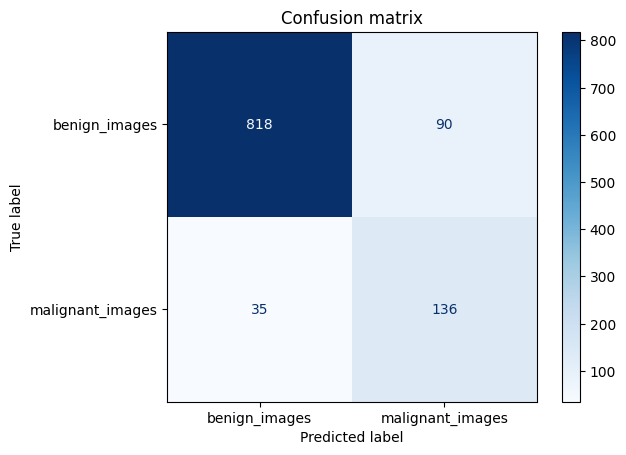

In [48]:

# Evaluar el modelo
all_labels, all_preds = evaluate_model(model, test_loader)
# Imprimir métricas
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))
# Graficar matriz de confusión
plot_confusion_matrix(all_labels, all_preds, classes=train_dataset.classes)

In [49]:
torch.save(model.state_dict(), 'melanoma_model_1_torch_EFFICIENTNETB0_harvard_2.pth')

In [50]:
import cv2
from PIL import Image

def predict_image(image_path, model):
    model.eval()
    img = Image.open(image_path)
    img = transform(img).unsqueeze(0).to(device)  # Aplicar las mismas transformaciones

    with torch.no_grad():
        output = model(img).squeeze()
        prediction = torch.sigmoid(output).item()
    
    if prediction > 0.5:
        print("🔴 Malignant melanoma")
    else:
        print("🟢 Benign melanoma")

# Prueba con una imagen nueva
predict_image(r'C:\Users\jakif\CODE\PROYECTO-FINAL\images\harvard_dataset\PREPROCESSED_DATA\final\train\benign_images\ISIC_0024306.jpg', model)  # Benigno
predict_image(r'C:\Users\jakif\CODE\PROYECTO-FINAL\images\harvard_dataset\PREPROCESSED_DATA\final\test\malignant_images\ISIC_0034529.jpg', model)  # Maligno

🟢 Benign melanoma
🔴 Malignant melanoma


Utilizando dispositivo: cuda
Cargando checkpoint desde: melanoma_model_1_torch_EFFICIENTNETB0_harvard_2.pth
Contenido del checkpoint:
  - features.0.0.weight
  - features.0.1.weight
  - features.0.1.bias
  - features.0.1.running_mean
  - features.0.1.running_var
  - features.0.1.num_batches_tracked
  - features.1.0.block.0.0.weight
  - features.1.0.block.0.1.weight
  - features.1.0.block.0.1.bias
  - features.1.0.block.0.1.running_mean
  - features.1.0.block.0.1.running_var
  - features.1.0.block.0.1.num_batches_tracked
  - features.1.0.block.1.fc1.weight
  - features.1.0.block.1.fc1.bias
  - features.1.0.block.1.fc2.weight
  - features.1.0.block.1.fc2.bias
  - features.1.0.block.2.0.weight
  - features.1.0.block.2.1.weight
  - features.1.0.block.2.1.bias
  - features.1.0.block.2.1.running_mean
  - features.1.0.block.2.1.running_var
  - features.1.0.block.2.1.num_batches_tracked
  - features.2.0.block.0.0.weight
  - features.2.0.block.0.1.weight
  - features.2.0.block.0.1.bias
  - feat

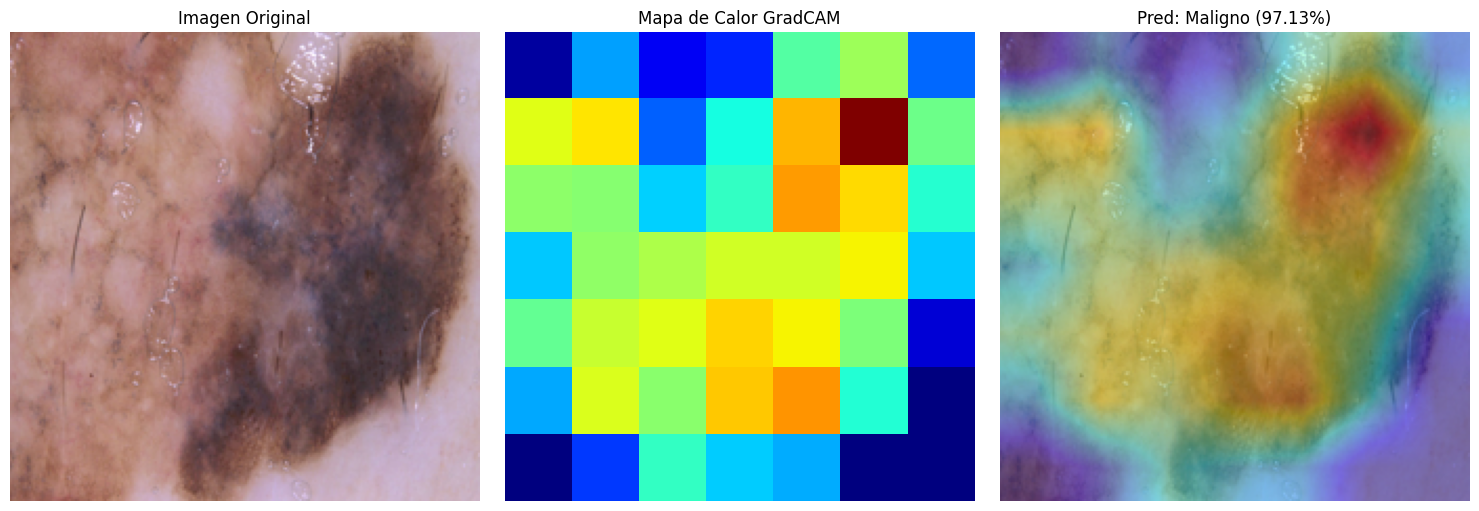

Resultado guardado en: gradcam_result.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# Implementación GradCAM con EfficientNet-B0
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms
import os

class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks for gradients and activations
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x):
        return self.model(x)

    def get_cam(self):
        # Ensure gradients and activations are available
        if self.gradients is None or self.activations is None:
            raise ValueError("Gradients or activations are not available. Perform a backward pass first.")

        # Move gradients and activations to the same device
        device = self.activations.device
        gradients = self.gradients.to(device)

        # Global Average Pooling
        weights = torch.mean(gradients, dim=[0, 2, 3])
        cam = torch.zeros(self.activations.shape[2:], dtype=torch.float32, device=device)

        for i in range(weights.shape[0]):
            cam += weights[i] * self.activations[0, i, :, :]

        cam = F.relu(cam)
        cam = cam - torch.min(cam)
        cam = cam / torch.max(cam)
        return cam.cpu().detach().numpy()
  
# Definir el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizando dispositivo: {device}")

# Definir transformaciones para la imagen
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Cargar el modelo EfficientNet-B0
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Modificar el clasificador para clasificación binaria
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(in_features=1280, out_features=512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(in_features=512, out_features=128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(in_features=128, out_features=1)
)

# Mover el modelo al dispositivo
model = model.to(device)

# Cargar los pesos del modelo desde un checkpoint
checkpoint_path = 'melanoma_model_1_torch_EFFICIENTNETB0_harvard_2.pth'
print(f"Cargando checkpoint desde: {checkpoint_path}")

try:
    # Verificar si el archivo existe
    if not os.path.exists(checkpoint_path):
        print(f"⚠️ ADVERTENCIA: No se encontró el archivo {checkpoint_path}")
    
    # Cargar checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Verificar el contenido del checkpoint
    print("Contenido del checkpoint:")
    for key in checkpoint.keys():
        print(f"  - {key}")
    
    # Si el checkpoint contiene 'model_state_dict', este es el formato habitual de guardado
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print("✅ Modelo cargado desde model_state_dict")
        
        # Opcionalmente, puedes imprimir información adicional
        if 'epoch' in checkpoint:
            print(f"Modelo entrenado por {checkpoint['epoch']} épocas")
        if 'val_f1' in checkpoint:
            print(f"F1 Score en validación: {checkpoint['val_f1']:.4f}")
    else:
        # Intentar cargar directamente como state_dict
        model.load_state_dict(checkpoint)
        print("✅ Modelo cargado directamente desde state_dict")
    
except Exception as e:
    print(f"❌ Error al cargar el modelo: {str(e)}")
    print("⚠️ Continuando con pesos preentrenados de ImageNet")

# Poner modelo en modo evaluación
model.eval()

# Obtener la última capa convolucional para GradCAM
# En EfficientNet-B0, la última capa convolucional está en features[-1]
try:
    target_layer = model.features[-1][0]  # Primera capa del último bloque de características
    print(f"Capa objetivo para GradCAM: {target_layer}")
except Exception as e:
    print(f"Error al acceder a la capa objetivo: {str(e)}")
    # Fallback a otra capa
    try:
        target_layer = model.features[-2][0]
        print(f"Usando capa alternativa: {target_layer}")
    except:
        print("No se pudo encontrar una capa adecuada para GradCAM")
        raise

# Crear el objeto GradCam
grad_cam = GradCam(model, target_layer)

# Ruta a la imagen (ajusta según sea necesario)
image_path = r'C:\Users\jakif\CODE\PROYECTO-FINAL\images\PREPROCESSED_DATA_copy\test\malignant_images\ISIC_00346.jpg'
print(f"Analizando imagen: {image_path}")

# Verificar si el archivo existe
if not os.path.exists(image_path):
    print(f"⚠️ ADVERTENCIA: No se encontró la imagen en {image_path}")

# Cargar y preprocesar la imagen
try:
    image = Image.open(image_path)
    # IMPORTANTE: NO usamos with torch.no_grad() aquí porque necesitamos gradientes para GradCAM
    image_tensor = transform(image).unsqueeze(0).to(device)
    print(f"Imagen cargada y transformada: {image_tensor.shape}")
except Exception as e:
    print(f"Error al cargar la imagen: {str(e)}")
    raise

# Para GradCAM necesitamos habilitar el tracking de gradientes
# Aseguramos que requires_grad está habilitado
image_tensor.requires_grad = True

# Forward pass
outputs = model(image_tensor)

# Obtener la clase predicha
predicted_prob = torch.sigmoid(outputs.squeeze()).item()
predicted_class = 1 if predicted_prob >= 0.5 else 0
print(f"Clase predicha: {predicted_class} (Probabilidad: {predicted_prob:.4f})")

# Backward pass para calcular gradientes
model.zero_grad()

# Crear un tensor para propagar hacia atrás
# Este es el punto crucial que estaba causando el error
if outputs.requires_grad:
    outputs.backward(retain_graph=True)
else:
    print("⚠️ ADVERTENCIA: El tensor de salida no tiene gradientes. Intentando solución alternativa...")
    # Creamos una salida que requiera gradientes
    output_with_grad = outputs.detach().requires_grad_(True)
    output_with_grad.backward(torch.ones_like(output_with_grad))

# Obtener el mapa de activación de clase
try:
    cam = grad_cam.get_cam()
    print("✅ GradCAM generado con éxito")
except Exception as e:
    print(f"❌ Error al generar GradCAM: {str(e)}")
    # En caso de error, crear un mapa de calor vacío
    cam = np.zeros((224, 224))
    print("⚠️ Se generará un mapa de calor vacío")

# Mostrar resultados
plt.figure(figsize=(15, 5))

# Imagen original
plt.subplot(1, 3, 1)
original_image = Image.open(image_path)
original_image_resized = original_image.resize((224, 224))
plt.imshow(original_image_resized)
plt.title("Imagen Original")
plt.axis('off')

# Mapa de calor de GradCAM
plt.subplot(1, 3, 2)
plt.imshow(cam, cmap='jet')
plt.title("Mapa de Calor GradCAM")
plt.axis('off')

# Superposición del mapa de calor sobre la imagen original
plt.subplot(1, 3, 3)
original_image_np = np.array(original_image_resized)
cam_resized = cv2.resize(cam, (original_image_resized.width, original_image_resized.height))
heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
overlay = cv2.addWeighted(original_image_np, 0.6, heatmap, 0.4, 0)
plt.imshow(overlay)
plt.title(f"Pred: {'Maligno' if predicted_class == 1 else 'Benigno'} ({predicted_prob:.2%})")
plt.axis('off')

plt.tight_layout()
plt.show()

# Guardar la imagen resultante
result_path = "gradcam_result.png"
plt.savefig(result_path)
print(f"Resultado guardado en: {result_path}")

# Limpiar memoria
del model
del grad_cam
torch.cuda.empty_cache()